# Text classification

Text classification has a broad range of applications:

- Tag customer feedback into categories
- Route support tickets
- Sentiment analysis

In this example, you will 

- Identify emotional states using a variant of BERT, [DistilBERT](https://www.google.com/url?q=https%3A%2F%2Farxiv.org%2Fabs%2F1910.01108), that will allow you to train a classifier in a few minutes.
- Use core libraries from [Hugging Face](https://huggingface.co/docs/huggingface_hub/index) to quickly go from raw text to a fine-tuned model that can be used for inference on new tweets:

    - Tokenizers
    - Transformers
 
- This example uses PyTorch, Hugging Face Transformers also provide tight interoperability with TensorFlow and JAX. See the [original code](https://github.com/nlp-with-transformers) for the details on how to smoothly transition between frameworks.

We will use four steps:

1. Load and process datasets
2. Tokenize input texts
3. Load models, train, and infer
4. Load metrics and evaluate models

This notebook is substantially taken from [NLP Transformers](https://github.com/nlp-with-transformers) as licensed under the  Apache License 2.0.
It has been updated to the current code versions and set up using Conda where possible to resolve package conflicts using conda environments and Docker containers. Some of the content has been simplified.

## Verify installation

Before we start, let's verify our environment. Using PyTorch to validate the CUDA environment has been set up.

In [1]:
import numpy as np
import pandas as pd
import torch

print(f'np: {np.__version__}')
print(f'pd: {pd.__version__}')

print(f'cuda enable: {torch.cuda.is_available()}')
print(f'current_device: {torch.cuda.current_device()}')
print(f'device: {torch.cuda.device(0)}')
print(f'device_count: {torch.cuda.device_count()}')
print(f'get_device_name: {torch.cuda.get_device_name(0)}')


np: 1.23.5
pd: 2.2.2
cuda enable: True
current_device: 0
device: <torch.cuda.device object at 0x7f4267244e90>
device_count: 1
get_device_name: NVIDIA GeForce RTX 3060 Laptop GPU


## Load and process datasets

Use `datasets` to download currated data from [Hugging Face Hub](https://huggingface.co/datasets). The following code lists the datasets available.

In [2]:
from datasets import list_datasets

all_datasets = list_datasets()
print(f"There are {len(all_datasets)} datasets currently available on the Hub")
print(f"The first 10 are: {all_datasets[:10]}")

/tmp/ipykernel_1371168/89111038.py:3: FutureWarning: list_datasets is deprecated and will be removed in the next major version of datasets. Use 'huggingface_hub.list_datasets' instead.
  all_datasets = list_datasets()


There are 200843 datasets currently available on the Hub
The first 10 are: ['amirveyseh/acronym_identification', 'ade-benchmark-corpus/ade_corpus_v2', 'UCLNLP/adversarial_qa', 'Yale-LILY/aeslc', 'nwu-ctext/afrikaans_ner_corpus', 'fancyzhx/ag_news', 'allenai/ai2_arc', 'google/air_dialogue', 'komari6/ajgt_twitter_ar', 'legacy-datasets/allegro_reviews']


Load the `dair-ai/emotion` dataset.

In [3]:
from datasets import load_dataset

emotions = load_dataset("dair-ai/emotion")

View the `emotions` objext

In [4]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

The datasets are already split. View the training data as a dataset named `train_ds`

In [5]:
train_ds = emotions["train"]
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

`Dataset` is one of the core data structures in [Hugging Face Datasets](https://huggingface.co/docs/datasets/index). They use the syntax of a Python array.

In [6]:
print(len(train_ds))
print(train_ds[0])
print(train_ds.column_names)

16000
{'text': 'i didnt feel humiliated', 'label': 0}
['text', 'label']


Datasets are based on [Appache Arrow](https://arrow.apache.org/) that uses a typed columnar format that you may recognize from Pandas, Apache Spark, Apache Parquet. See [Products using Apache Arrow](https://arrow.apache.org/powered_by/).

In [7]:
print(train_ds.features) # to see datatypes
print('---')
print(train_ds[:5]) # to access several rows of the data
print('---')
print(train_ds["text"][:5]) # to access a column of data by name


{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}
---
{'text': ['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy'], 'label': [0, 0, 3, 2, 3]}
---
['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy']


### Use DataFrames for your DataSets

You will probably want to convert `DataSet` into a `DataFrame`. DataSets provide `set_format()` method. The underlying Arrow tables are not changed, and you can change formats later. For example, `torch` returns PyTorch tensors and `tensorflow` returns TensorFlow tensors.

In [8]:
import pandas as pd

emotions.set_format(type="pandas")
df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


The `label` column is represented by integers. Use `int2str` to create a new column in the `DataFrame` to see the label names.

In [9]:
def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


### Exploratory Data Analysis

#### Univariate analysis

Determine if the emotions data is balanced.

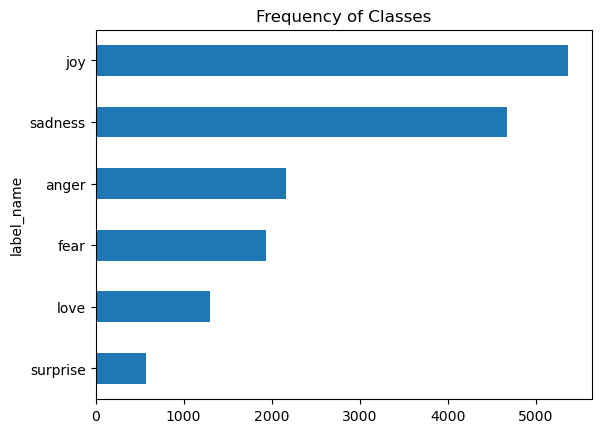

In [10]:
import matplotlib.pyplot as plt

df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

**Observations**

The frequency of classes is heavily imbalanced with `joy` and `sadness` apprearing frequently, with `love` and `suprise` infrequently.

To learn more about how to deal with imbalanced data, see [Imbalance-learn](https://imbalanced-learn.org/stable/) documentation.

Transformer models have a maximum input sequence length that is referred to as the maximum context size. For applications using DistilBERT, the maximum context size is 512 tokens, which amounts to a few paragraphs of text. As we'll see in the next section, a token is an atomic piece of text; for now, we'll treat a token as a single word. 

#### Bivariage analysis

Transformer models have a maximum input sequence length that is referred to as the _maximum context size_. For applications using DistilBERT, the maximum context size is 512 tokens, which amounts to a few paragraphs of text. As we'll see in the next section, a token is an atomic piece of text; for now, we'll treat a token as a single word. 

Estimate the tweet lengths for each emotion

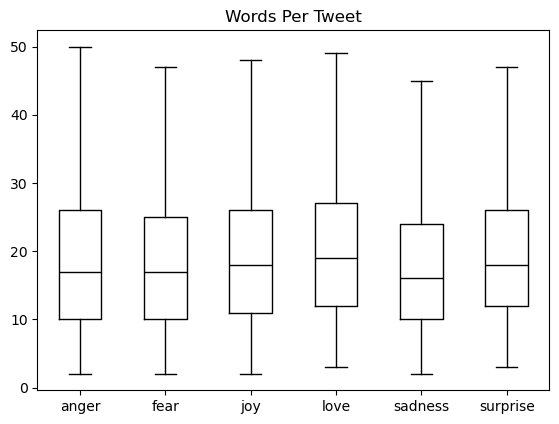

In [11]:
df["Words Per Tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words Per Tweet", by="label_name", grid=False, showfliers=False,
           color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

**Observation**

Most tweets are around 15 words long and the longest tweets are well below DistilBERT's maximum context size.

Texts that are longer than a model's context size need to be truncated, which can lead to a loss in performance if the truncated text contains crucial information; in this case, it looks like that won't be an issue.

In [12]:
emotions.reset_format() # Back to dataset because we no longer need DataFrame

## Tokenize input texts

Transformer models like DistilBERT cannot receive raw strings as input; instead, they assume the text has been tokenized and encoded as numerical vectors. 

Rather than tokenize _character_ or _word_, let's use subword tokenization

The basic idea behind subword tokenization is to combine the best aspects of character and word tokenization. On the one hand, we want to split rare words into smaller units to allow the model to deal with complex words and misspellings. On the other hand, we want to keep frequent words as unique entities so that we can keep the length of our inputs to a manageable size. The main distinguishing feature of subword tokenization (as well as word tokenization) is that it is learned from the pretraining corpus using a mix of statistical rules and algorithms.

There are several subword tokenization algorithms that are commonly used in NLP,  but let's start with [WordPiece]() that is used by BERT and DistilBERT tokenizers. 

Hugging Face Tranformers provides `AutoTokenizer` class to load the tokenizer associated with the pre-trained model. We find out what the model is by calling `from_pretrained` and provide the model on the Hub or local file path. 

In [13]:
# Load the tokenizer for DistilBERT
from transformers import AutoTokenizer

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

/home/bruce/anaconda3/envs/text_classification/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Let's examine how this tokenizer works by feeding it our simple "Tokenizing text is a core task of NLP." example text:

In [14]:
text = "Tokenizing text is a core task of NLP."
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


The words have been mapped to unique integers in the `input_ids` field.

We can convert the `input_ids` back to tokens using tokenizer's `convert_ids_to_tokens()` method

In [15]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '.', '[SEP]']


**Observations**

- Some special [CLS] and [SEP] tokens have been added to the start and end of the sequence. These tokens differ from model to model, but their main role is to indicate the start and end of a sequence.
- Tokens have each been lowercased, which is a feature of this particular checkpoint.
- "tokenizing" and "NLP" have been split into two tokens. The ## prefix in ##izing and ##p means that the preceding string is not whitespace; any token with this prefix should be merged with the previous token when you convert the tokens back to a string.


In [16]:
# Get tokened string back to the original
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] tokenizing text is a core task of nlp. [SEP]


Inspect vocabulary size

In [17]:
tokenizer.vocab_size

30522

Model's maximum context size

In [18]:
tokenizer.model_max_length

512

Inspect the names of the fields that the model expects in its forward pass

In [19]:
tokenizer.model_input_names

['input_ids', 'attention_mask']

Now that we have a basic understanding of the tokenization process for a single string, let's see how we can tokenize the whole dataset

IMPORTANT:
When using pretrained models, it is really important to make sure that you use the same tokenizer that the model was trained with. From the model's perspective, switching the tokenizer is like shuffling the vocabulary.

### Tokenizing the whole dataset

To tokenize the whole corpus, we'll use the `map()` method of our `DatasetDict` object. 

`map()` method can also be used to create new rows and columns.

The following function applies the tokenizer to a batch of examples:

- `padding=True` pads the examples with zeros to the size of the longest one in a batch
- `truncation=True` truncates the examples to the model's maximum context size.

In [20]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

Try it with two examples from the training set.

In [21]:
print(tokenize(emotions["train"][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


Next, let's inspect the nature of the tokenized results.

**Observatons**

- The result of padding: the first element of `input_ids` is shorter than the second, so zeros have been added to that element to make them the same length.
- These zeros have a corresponding [PAD] token in the vocabulary
- The set of special tokens also includes the [CLS] and [SEP] tokens

In [22]:
tokens2ids = list(zip(tokenizer.all_special_tokens, tokenizer.all_special_ids))
data = sorted(tokens2ids, key=lambda x : x[-1])
df = pd.DataFrame(data, columns=["Special Token", "Special Token ID"])
df.T

,0,1,2,3,4
Special Token,[PAD],[UNK],[CLS],[SEP],[MASK]
Special Token ID,0,100,101,102,103


The tokenizer aslo returns a list of `attention_mask` arrays.

So the model will not get confused by the additional padding tokens: the attention mask allows the model to ignore the padded parts of the input.

<img alt="attnention-mask" caption="For each batch, the input sequences are padded to the maximum sequence length in the batch; the attention mask is used in the model to ignore the padded areas of the input tensors" src="media/attention-mask.png" id="attention-mask"/> 

Once we've defined a processing function, we can apply it across all the splits in the corpus in a single line of code.

`map()` operates individually on every example in the corpus, so setting `batched=True` will encode the tweets in batches. Because we've set `batch_size=None`, `tokenize()` will be applied on the full dataset as a single batch. 

In [23]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

In [24]:
print(emotions_encoded["train"].column_names)

['text', 'label', 'input_ids', 'attention_mask']


**Observation**

- The input tensors and attention masks have the same shape globally
- New `input_ids` and `attention_mask` columns to the dataset

## Training a text classifier

Models like DistilBERT are pretrained to predict masked words in a sequence of text. 

But they aren't ready yet to directly do text classification. 

We have two options to train such a model on our Twitter dataset:

- _Feature extraction_. Use the hidden states as features and train a classifier on them, without modifiying the pretrained model.
- _Fine-tuning_. Train the whole model end-to-end, which also updates the parameters of the pretrained model.
Let's explore both and examine the trade offs.el.

### Feature extraction

When using a transformer as a feature extractor, freeze the body's weights during training and use the hidden states as features for the classifier. The advantage of this approach is that we can quickly train a small or shallow model. Such a model could be a neural classification layer or a method that does not rely on gradients, such as a random forest. This method is especially convenient if GPUs are unavailable, since the hidden states only need to be precomputed once.

<img alt="encoder-features" caption="In the feature-based approach, the DistilBERT model is frozen and just provides features for a classifier" src="media/encoder-feature-based.png" id="encoder-features"/>

Hugging Face Transfomers has a convenient auto class called `AutoModel`. It is similar to `AutoTokenizer` class, `AutoModel` has a `from_pretrained()` methodto load weights of the pretrained model.

Let's load the DistilBERT checkpoint:

In [25]:
from transformers import AutoModel

model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

The preceding code uses PyTorch to check whether a GPU is available or not, and then chained the PyTorch `nn.Module.to()` method to the model loader. 

The `AutoModel` class converts the token encodings to embeddings, and then feeds them through the encoder stack to return the hidden states. Let's take a look at how we can extract these states from our corpus.

#### Extracting the last hidden states

Let's retrieve the last hidden states for a single string. The first thing we need to do is encode the string and convert the tokens to PyTorch tensors. This can be done by providing the `return_tensors="pt"` argument to the tokenizer

In [26]:
text = "this is a test"
inputs = tokenizer(text, return_tensors="pt")
print(f"Input tensor shape: {inputs['input_ids'].size()}")

Input tensor shape: torch.Size([1, 6])


the resulting tensor has the shape `[batch_size, n_tokens]`. Now that we have the encodings as a tensor, the final step is to place them on the same device as the model and pass the inputs

In [27]:
inputs = {k:v.to(device) for k,v in inputs.items()}
with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]],
       device='cuda:0'), hidden_states=None, attentions=None)


Here we've used the `torch.no_grad()` context manager to disable the automatic calculation of the gradient. This is useful for inference since it reduces the memory footprint of the computations. 

Depending on the model configuration, the output can contain several objects, such as the hidden states, losses, or attentions, arranged in a class similar to a `namedtuple` in Python. In our example, the model output is an instance of `BaseModelOutput`, and we can simply access its attributes by name. The current model returns only one attribute, which is the last hidden state, so let's examine its shape:

In [28]:
outputs.last_hidden_state.size()

torch.Size([1, 6, 768])

Looking at the hidden state tensor, we see that it has the shape `[batch_size, n_tokens, hidden_dim]`. In other words, a 768-dimensional vector is returned for each of the 6 input tokens. For classification tasks, it is common practice to just use the hidden state associated with the `[CLS]` token as the input feature. Since this token appears at the start of each sequence, we can extract it by simply indexing into outputs.last_hidden_state as follows:

In [29]:
outputs.last_hidden_state[:,0].size()

torch.Size([1, 768])

Now that we know how to get the last hidden state for a single string, let's do the same thing for the whole dataset by creating a new `hidden_state` column that stores all these vectors. As we did with the tokenizer, we'll use the `map()` method of `DatasetDict` to extract all the hidden states in one go. 

The first thing we need to do is wrap the previous steps in a processing function:

In [30]:
def extract_hidden_states(batch):
    # Place model inputs on the GPU
    inputs = {k:v.to(device) for k,v in batch.items() 
              if k in tokenizer.model_input_names}
    # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

The only difference between this function and our previous logic is the final step where we place the final hidden state back on the CPU as a NumPy array. The `map()` method requires the processing function to return Python or NumPy objects when we're using batched inputs.

Since our model expects tensors as inputs, the next thing to do is convert the `input_ids` and `attention_mas`k columns to the "torch" format, as follows:

In [31]:
emotions_encoded.set_format("torch", 
                            columns=["input_ids", "attention_mask", "label"])

Extract the hidden states across all splits in one go

In [32]:
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

Note that we did not set `batch_size=None` in this case, so the default `batch_size=1000` is used instead. As expected, applying the `extract_​hid⁠den_​states()` function has added a new hidden_state column to our dataset:

In [33]:
emotions_hidden["train"].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

Now that we have the hidden states associated with each tweet, the next step is to train a classifier on them. To do that, we'll need a feature matrix.

#### Create a feature matrix

The preprocessed dataset now contains all the information we need to train a classifier on it. We will use the hidden states as input features and the labels as targets. We can easily create the corresponding arrays in the well-known Scikit-Learn format

In [34]:
import numpy as np

X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])
X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

Before we train a model on the hidden states, it's good practice to perform a sanity check to ensure that they provide a useful representation of the emotions we want to classify. In the next section, we'll see how visualizing the features provides a fast way to achieve this

#### Visualize the training set

Since visualizing the hidden states in 768 dimensions is tricky to say the least, we'll use the powerful [UMAP](https://arxiv.org/abs/1802.03426) algorithm to project the vectors into 2D.

Since UMAP works best when the features are scaled to lie in the [0,1] interval, we'll first apply a `MinMaxScaler` and then use the UMAP implementation from the umap-learn library to reduce the hidden states

In [35]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

# Scale features to [0,1] range
X_scaled = MinMaxScaler().fit_transform(X_train)
# Initialize and fit UMAP
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
# Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

,X,Y,label
0,4.022203,6.018363,0
1,-3.174545,5.178780,0
2,4.911689,2.739875,3
3,-2.659470,3.074447,2
4,-3.497692,3.297086,3


The result is an array with the same number of training samples, but with only 2 features instead of the 768 we started with! Let's investigate the compressed data a little bit further and plot the density of points for each category separately:

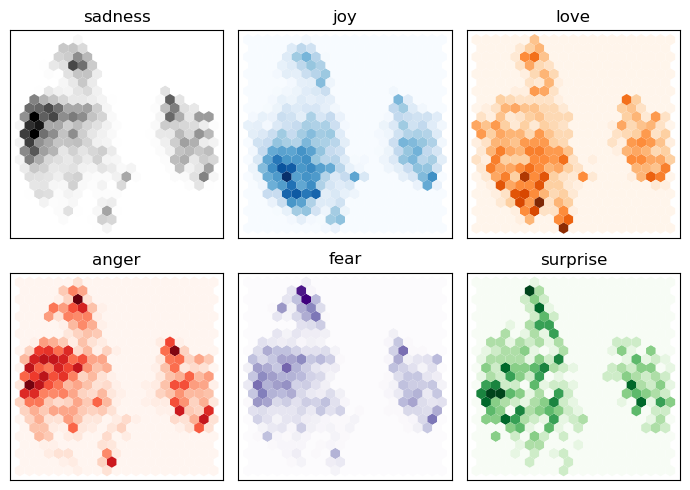

In [36]:
fig, axes = plt.subplots(2, 3, figsize=(7,5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = emotions["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
                   gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()

**Observations**

From this plot we can see some clear patterns: 

- The negative feelings such as `sadness`, `anger`, and `fear` all occupy similar regions with slightly varying distributions.
- `joy` and `love` are well separated from the negative emotions and also share a similar space. Finally, surprise is scattered all over the place. Although we may have hoped for some separation, this is in no way guaranteed since the model was not trained to know the difference between these emotions. It only learned them implicitly by guessing the masked words in texts.

#### Training a simple classifier

We've seen that the hidden states are somewhat different between the emotions, although for several of them there is no obvious boundary. Let's use these hidden states to train a logistic regression model with Scikit-Learn. Training such a simple model is fast and does not require a GPU:

In [37]:
# We increase `max_iter` to guarantee convergence 
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)

LogisticRegression(max_iter=3000)

In [38]:
lr_clf.score(X_valid, y_valid)

0.6335

**Observation**

Looking at the accuracy, it might appear that our model is just a bit better than random—but since we are dealing with an unbalanced multiclass dataset, it's actually significantly better. 

We can examine whether our model is any good by comparing it against a simple baseline. 

In Scikit-Learn there is a `DummyClassifier` that can be used to build a classifier with simple heuristics such as always choosing the majority class or always drawing a random class. In this case the best-performing heuristic is to always choose the most frequent class, which yields an accuracy of about 35%:

In [39]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.352

So, our simple classifier with DistilBERT embeddings is significantly better than our baseline. We can further investigate the performance of the model by looking at the confusion matrix of the classifier, which tells us the relationship between the true and predicted labels

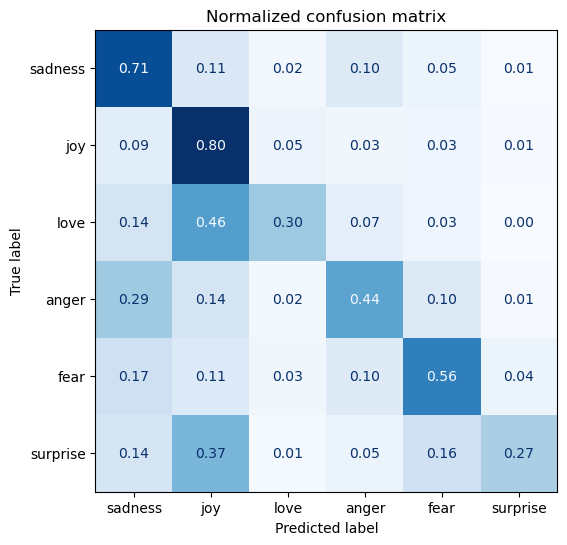

In [40]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()
    
y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

**Observation**

- `anger` and `fear` are most often confused with sadness, which agrees with the observation we made when visualizing the embeddings.
- `love` and `surprise` are frequently mistaken for `joy`.

In the next section we will explore the fine-tuning approach, which leads to superior classification performance. It is, however, important to note that doing this requires more computational resources, such as GPUs, that might not be available in your organization. In cases like these, a feature-based approach can be a good compromise between doing traditional machine learning and deep learning.

### Fine-tuning transformers

Let's explore what it takes to fine-tune a transformer end-to-end. With the fine-tuning approach we do not use the hidden states as fixed features, but instead train them as shown un the following illustration. This requires the classification head to be differentiable, which is why this method usually uses a neural network for classification.

<img alt="encoder-tuning" caption="When using the fine-tuning approach the whole DistilBERT model is trained along with the classification head" src="media/encoder-fine-tuning.png" id="encoder-tuning"/>

Training the hidden states that serve as inputs to the classification model will help us avoid the problem of working with data that may not be well suited for the classification task. Instead, the initial hidden states adapt during training to decrease the model loss and thus increase its performance.

Let's use `Trainer` API from Hugging Face Transformers to simplify the training loop. 

#### Load a pretrained model

The first thing we need is a pretrained DistilBERT model like the one we used in the feature-based approach. The only slight modification is that we use the `AutoModelForSequenceClassification` model instead of `AutoModel`. 

The difference is that the `AutoModelForSequenceClassification` model has a classification head on top of the pretrained model outputs, which can be easily trained with the base model. We just need to specify how many labels the model has to predict (six in our case), since this dictates the number of outputs the classification head has

In [41]:
from transformers import AutoModelForSequenceClassification

num_labels = 6
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels)
         .to(device))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


You will see a warning that some parts of the model are randomly initialized. This is normal since the classification head has not yet been trained. 

#### Define the performance metrics

To monitor metrics during training, we need to define a `compute_metrics()` function for the `Trainer`. This function receives an `EvalPrediction` object (which is a named tuple with `predictions` and `label_ids` attributes) and needs to return a dictionary that maps each metric's name to its value. For our application, we'll compute the $F_1$-score and the accuracy of the model :

In [42]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

#### Train the model

With the dataset and metrics ready, we just have two final things to take care of before we define the `Trainer` class:

1. Log in to our account on the Hugging Face Hub. This will allow us to push our fine-tuned model to our account on the Hub and share it with the community.
2. Define all the hyperparameters for the training run.

In [43]:
from huggingface_hub import notebook_login

notebook_login()

This will display a widget in which you can enter your username and password, or an access token with write privileges. You can find details on how to create access tokens in the [Hub documentation](https://huggingface.co/docs/hub/security#user-access-tokens). If you're working in the terminal, you can log in by running the following command:

```bash
huggingface-cli login
```

Use the `TrainingArguments` class to define the training parameters. This class stores a lot of information and gives you fine-grained control over the training and evaluation. Be sure to specify `output_dir`, where all the artifacts from training are stored. Set the batch size, learning rate, and number of epochs, and specify to load the best model at the end of the training run.

In [44]:
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  eval_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=True, 
                                  log_level="error")

Next, instantiate and fine-tune our model with the `Trainer`.

In [45]:
from transformers import Trainer

trainer = Trainer(model=model, args=training_args, 
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded["train"],
                  eval_dataset=emotions_encoded["validation"],
                  tokenizer=tokenizer)
trainer.train();

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.830200,0.316089,0.908500,0.908341
2,0.248900,0.212430,0.926000,0.925895


**Observations**

The model has an $F_1$-score on the validation set of around 92% - this is a significant improvement over the feature-based approach

Let's take a more detailed look at the training metrics by calculating the confusion matrix. The `predict()` method of the `Trainer` class returns several useful objects we can use for evaluation.

In [46]:
preds_output = trainer.predict(emotions_encoded["validation"])

The output of the `predict()` method is a `PredictionOutput` object that contains arrays of `predictions` and `label_ids`, along with the metrics we passed to the trainer.

To access the metrics on the validation set:

In [47]:
preds_output.metrics

{'test_loss': 0.21243005990982056,
 'test_accuracy': 0.926,
 'test_f1': 0.9258950295938757,
 'test_runtime': 3.3203,
 'test_samples_per_second': 602.359,
 'test_steps_per_second': 9.638}

It also contains the raw predictions for each class. We can decode the predictions greedily using `np.argmax()`. This yields the predicted labels and has the same format as the labels returned by the Scikit-Learn models in the feature-based approach

In [48]:
y_preds = np.argmax(preds_output.predictions, axis=1)

With the predictions, we can plot the confusion matrix again:

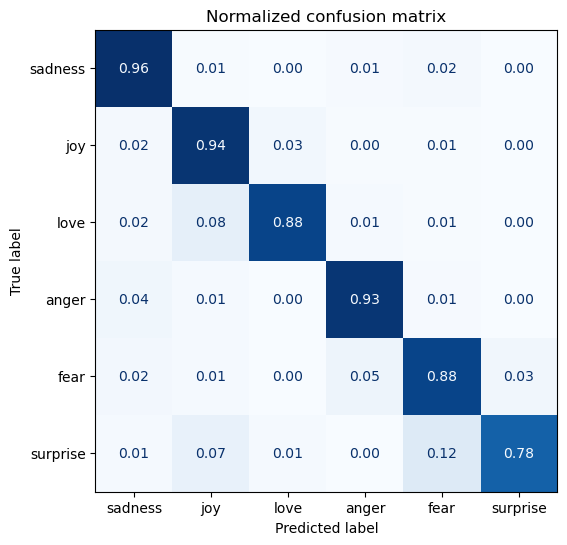

In [49]:
plot_confusion_matrix(y_preds, y_valid, labels)

**Observations**

This is much closer to the ideal diagonal confusion matrix. The `love` category is still often confused with `joy`, which seems natural. `surprise` is also frequently mistaken for `joy`, or confused with `fear`. 
Overall the performance of the model seems quite good

#### Error analysis

Let's investigate our model's predictions a little bit further. A simple yet powerful technique is to sort the validation samples by the model loss. When we pass the label during the forward pass, the loss is automatically calculated and returned. Here's a function that returns the loss along with the predicted label

In [50]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # Place all input tensors on the same device as the model
    inputs = {k:v.to(device) for k,v in batch.items() 
              if k in tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device), 
                             reduction="none")

    # Place outputs on CPU for compatibility with other dataset columns   
    return {"loss": loss.cpu().numpy(), 
            "predicted_label": pred_label.cpu().numpy()}

Using the `map()` method to get the losses for all the samples

In [51]:
# Convert our dataset back to PyTorch tensors
emotions_encoded.set_format("torch", 
                            columns=["input_ids", "attention_mask", "label"])
# Compute loss values
emotions_encoded["validation"] = emotions_encoded["validation"].map(
    forward_pass_with_label, batched=True, batch_size=16)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Create a `DataFrame` with the texts, losses, and predicted/true labels

In [52]:
emotions_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = emotions_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"]
                              .apply(label_int2str))

We can now easily sort `emotions_encoded` by the losses in either ascending or descending order. The goal of this exercise is to detect one of the following

- **Wronglabel**. Every process that adds labels to data can be flawed. Annotators can make mistakes or disagree, while labels that are inferred from other features can be wrong. If it was easy to automatically annotate data, then we would not need a model to do it. Thus, it is normal that there are some wrongly labeled examples. With this approach, we can quickly find and correct them.

- **Quirks of the dataset**. Datasets in the real world are always a bit messy. When working with text, special characters or strings in the inputs can have a big impact on the model's predictions. Inspecting the model's weakest predictions can help identify such features, and cleaning the data or injecting similar examples can make the model more robust.

Let's first have a look at the data samples with the highest losses:

In [53]:
df_test.sort_values("loss", ascending=False).head(10)

,text,label,predicted_label,loss
1870,i guess i feel betrayed because i admired him ...,joy,sadness,6.003632
1963,i called myself pro life and voted for perry w...,joy,sadness,5.703990
1801,i feel that he was being overshadowed by the s...,love,sadness,5.297394
1500,i guess we would naturally feel a sense of lon...,anger,sadness,5.289473
1274,i am going to several holiday parties and i ca...,joy,sadness,4.987614
1950,i as representative of everything thats wrong ...,surprise,sadness,4.853735
318,i felt ashamed of these feelings and was scare...,fear,sadness,4.691357
1509,i guess this is a memoir so it feels like that...,joy,fear,4.553526
1111,im lazy my characters fall into categories of ...,joy,fear,4.259669
1964,i feel vaguely cheated and a little amused,joy,anger,4.257040


**Observations**

- The model predicted some of the labels incorrectly. 
- It seems that there are quite a few examples with no clear class, which might be either mislabeled or require a new class altogether.
- In particular, `joy` seems to be mislabeled several times.

**Follow up**

Refine the dataset, which often can lead to as big a performance gain (or more) as having more data or larger models

Next consider the samples with the lowest losses. Deep learning models are exceptionally good at finding and exploiting shortcuts to get to a prediction. For this reason, it is also worth investing time into looking at the examples that the model is most confident about, so that we can be confident that the model does not improperly exploit certain features of the text.

In [54]:
df_test.sort_values("loss", ascending=True).head(10)

,text,label,predicted_label,loss
1861,im tired of feeling lethargic hating to work o...,sadness,sadness,0.013266
1310,i feel like an ungrateful asshole,sadness,sadness,0.013268
69,i have no extra money im worried all of the ti...,sadness,sadness,0.013431
1452,i always feel guilty and come to one conclusio...,sadness,sadness,0.013692
244,im kinda relieve but at the same time i feel d...,sadness,sadness,0.013746
1466,i feel so ungrateful to be wishing this pregna...,sadness,sadness,0.013760
697,i was missing him desperately and feeling idio...,sadness,sadness,0.013854
1965,i started feeling pathetic and ashamed,sadness,sadness,0.013934
34,i feel that i m so pathetic and downright dumb...,sadness,sadness,0.013953
133,i and feel quite ungrateful for it but i m loo...,sadness,sadness,0.013960


**Observation**

The model seems to be most confident when predicting the `sadness` class. 
We now know that the `joy` is sometimes mislabeled and that the model is most confident about predicting the label `sadness`.

**Follow up**

Make targeted improvements to our dataset, and also keep an eye on the class the model seems to be very confident about.

### Save and share the model

The NLP community benefits greatly from sharing pretrained and fine-tuned models, and everybody can share their models with others via the Hugging Face Hub. Any community-generated model can be downloaded from the Hub just like we downloaded the DistilBERT model. 

In [55]:
trainer.push_to_hub(commit_message="Training completed!")

CommitInfo(commit_url='https://huggingface.co/brucedkyle/distilbert-base-uncased-finetuned-emotion/commit/113efbf29b38022ec105673beb0a0989af4d7444', commit_message='Training completed!', commit_description='', oid='113efbf29b38022ec105673beb0a0989af4d7444', pr_url=None, pr_revision=None, pr_num=None)

Use the fine-tuned model to make predictions on new tweets. Since we've pushed our model to the Hub, we can now use it with the `pipeline()` function.

In [56]:
from transformers import pipeline

# Change `transformersbook` to your Hub username
model_id = "transformersbook/distilbert-base-uncased-finetuned-emotion"
classifier = pipeline("text-classification", model=model_id)

config.json:   0%|          | 0.00/872 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/333 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/home/bruce/anaconda3/envs/text_classification/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Let's test the pipeline with a sample comment.

In [57]:
custom_comment = "I saw a movie today and it was really good."
preds = classifier(custom_comment, return_all_scores=True)

/home/bruce/anaconda3/envs/text_classification/lib/python3.11/site-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


Let's plot the probability for each class in a bar plot. Clearly, the model estimates that the most likely class is joy, which appears to be reasonable given the tweet

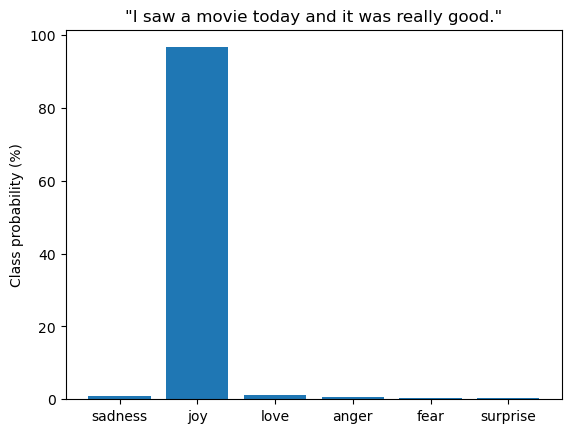

In [59]:
preds_df = pd.DataFrame(preds[0])
plt.bar(labels, 100 * preds_df["score"], color='C0')
plt.title(f'"{custom_comment}"')
plt.ylabel("Class probability (%)")
plt.show()

## Conclusion

you now know how to train a transformer model to classify the emotions in tweets! We have seen two complementary approaches based on features and fine-tuning, and investigated their strengths and weaknesses.

When a model is pushed to the Hub, an inference endpoint is automatically created that can be called with HTTP requests. We recommend checking out the documentation of the [Inference API](https://huggingface.co/docs/api-inference/index) if you want to learn more.

For more details see

## Book citation

```json
@book{tunstall2022natural,
  title={Natural Language Processing with Transformers: Building Language Applications with Hugging Face},
  author={Tunstall, Lewis and von Werra, Leandro and Wolf, Thomas},
  isbn={1098103246},
  url={https://books.google.ch/books?id=7hhyzgEACAAJ},
  year={2022},
  publisher={O'Reilly Media, Incorporated}
}
```